In [13]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import time
import pandas as pd
import os
import seaborn as sns
# from keras.applications.Xception import Xception
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.layers import MaxPool2D ,ReLU,Lambda,TimeDistributed,Dense, GlobalAveragePooling2D, Dropout,LSTM,Conv2D,MaxPooling2D,Flatten,BatchNormalization
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import CSVLogger

import os
import random

import numpy as np
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from PIL import Image, ImageOps
import matplotlib.image as mpimg

from keras.models import model_from_json

Characters

In [14]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def remove_background(img):
    #img1 = rgb2gray(img)
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img2 = img
    #blur = cv2.GaussianBlur(img1,(3,3),0)
    #ret,thresh1 = cv2.threshold(img1,225,255,cv2.THRESH_BINARY_INV)
    thresh1 = cv2.adaptiveThreshold(img1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,133,5)
    
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    b,g,r = cv2.split(img2)
    for i in range(closing.shape[0]):
      for j in range(closing.shape[1]):
        if(closing[i,j])==0:
          b[i,j] = 0
          g[i,j] = 0
          r[i,j] = 0

    newimg = cv2.merge((b,g,r))
    return newimg

def LoadPreProcessesAndSave(imgPath, savePath):
    img = plt.imread(imgPath)
    #plt.imshow(img)
    img = remove_background(img)
    #plt.imshow(img)
    #plt.imsave(img, savePath)
    plt.imsave(savePath,img)
    #img.save(savePath)
    



In [17]:
batch_size = 50
image_height=71
image_width=71
train_path = '/kaggle/input/isharalipi-sign-language/isharalipi/gestures/training_set'     

test_path =  '/kaggle/input/isharalipi-sign-language/isharalipi/gestures/testing_set'  
train_datagenerator = ImageDataGenerator(
        shear_range=0.2,
#         zoom_range=0.2,
        horizontal_flip=True,
        rescale=1./255,
vertical_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range=0.3,
    rotation_range=15,
)

test_datagenerator = ImageDataGenerator(rescale=1./255)
train_generator = train_datagenerator.flow_from_directory(train_path,
                                                          target_size = (75, 75),
                                                          color_mode = 'rgb',
                                                          batch_size = batch_size,
                                                          class_mode = 'categorical',
                                                          shuffle = True)


test_generator = test_datagenerator.flow_from_directory(test_path,
                                                        target_size = (75, 75),
                                                        color_mode = 'rgb',
                                                        class_mode = 'categorical',
                                                       shuffle=False
                                                       )

#Load model wothout classifier/fully connected layers
model = tf.keras.applications.InceptionResNetV2(weights='imagenet',input_shape=(75, 75,3), classes=36,include_top=False)

#for layer in model.layers:
#    layer.trainable = False

flat1 = Flatten()(model.layers[-1].output)

class1 = Dense(1024, activation='relu')(flat1)
# class2 = Dropout(0.2)(class1)
class3 = Dense(512, activation='relu')(class1)
# class4 = Dropout(0.2)(class3)
class5 = Dense(256, activation='relu')(class3)
# class6 = Dropout(0.2)(class5)
class7 = Dense(128, activation='relu')(class5)
# class8 = Dropout(0.2)(class7)
x = class7
output = Dense(10, activation='softmax')(x)
# define new model
model = Model(inputs=model.inputs, outputs=output)

model.compile(optimizer = keras.optimizers.SGD(learning_rate=keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)),loss='categorical_crossentropy',metrics = ['accuracy'])

Found 925 images belonging to 10 classes.
Found 150 images belonging to 10 classes.


In [27]:
class_names_train=os.listdir(train_path)
class_names_test=os.listdir(test_path)
print(class_names_train)
print(class_names_test)

['7', '2', '5', '8', '0', '3', '1', '4', '9', '6']
['7', '2', '5', '8', '0', '3', '1', '4', '9', '6']


In [28]:
start_time = time.time()

csv_logger = CSVLogger('training_Inception_resnet_V2_character.log', separator=',', append=False)
history1=model.fit(
        train_generator,
        verbose = 1,
        steps_per_epoch=train_generator.samples//batch_size,
        epochs=10,
        
        validation_data=train_generator,
        validation_steps=train_generator.samples//batch_size,
        callbacks=[csv_logger]
)

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/10
18/18 [==============================] - 5s 275ms/step - loss: 0.2151 - accuracy: 0.9211 - val_loss: 0.1543 - val_accuracy: 0.9633
Epoch 2/10
18/18 [==============================] - 5s 280ms/step - loss: 0.2293 - accuracy: 0.9211 - val_loss: 0.1455 - val_accuracy: 0.9511
Epoch 3/10
18/18 [==============================] - 5s 273ms/step - loss: 0.2150 - accuracy: 0.9291 - val_loss: 0.1827 - val_accuracy: 0.9467
Epoch 4/10
18/18 [==============================] - 5s 270ms/step - loss: 0.2390 - accuracy: 0.9177 - val_loss: 0.1490 - val_accuracy: 0.9456
Epoch 5/10
18/18 [==============================] - 5s 259ms/step - loss: 0.1832 - accuracy: 0.9371 - val_loss: 0.1730 - val_accuracy: 0.9478
Epoch 6/10
18/18 [==============================] - 5s 258ms/step - loss: 0.2142 - accuracy: 0.9234 - val_loss: 0.1678 - val_accuracy: 0.9489
Epoch 7/10
18/18 [==============================] - 5s 273ms/step - loss: 0.1669 - accuracy: 0.9417 - val_loss: 0.1504 - val_accuracy: 0.9533
Epoch 

In [ ]:
# from keras.models import model_from_json
# # load json and create model
# json_file = open('/kaggle/input/Xception-rdf/model_Xception_characters.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("/kaggle/input/Xception-rdf/model_Xception_characters.h5")
# model=loaded_model
# print("Loaded model from disk")

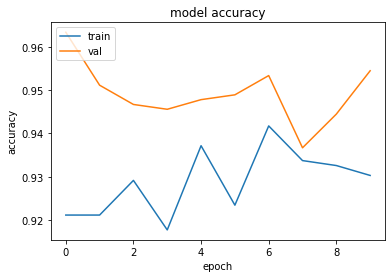

In [29]:
from matplotlib import pyplot as plt

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

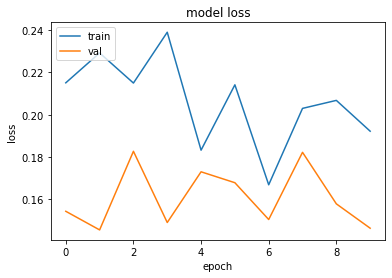

In [30]:
from matplotlib import pyplot as plt

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model_Xception_characters.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_Xception_characters.h5")
print("Saved model to disk")

In [32]:
model_pred = model.evaluate(test_generator)

5/5 [==============================] - 0s 39ms/step - loss: 0.3046 - accuracy: 0.9067


In [ ]:

# Read input images and assign labels based on folder names
# print(os.listdir("/kaggle/input/isharalipi-characters/database/training/"))

SIZE = 71  #Resize images

#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("/kaggle/working/database/training/*"):
    label = directory_path.split("/")[-1]
#     print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
#         print(img_path)
#         print("done")
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)


# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("/kaggle/working/database/testing/*"):
    fruit_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0



#One hot encode y values for neural network. 
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

#############################

# #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
# for layer in VGG_model.layers:
# 	layer.trainable = False
    
# VGG_model.summary()  #Trainable parameters will be 0




#Now, let us use features from convolutional network for RF

feature_extractor=fe.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_RF = features #This is our X input to RF

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 825, random_state = 42)

# Train the model on training data
start_time = time.time()

RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

print("--- %s seconds ---" % (time.time() - start_time))

#Send test data through same feature extractor process
X_test_feature = fe.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction_RFs = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RFs)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(test_labels, prediction_RF)
# #print(cm)
# sns.heatmap(cm, annot=True)
for i in confusion_matrix(test_labels, prediction_RF):
    print(i)
import sklearn.metrics as metrics
report = metrics.classification_report(y_test, prediction_RFs)
print(report)

import scikitplot as skplt
import matplotlib.pyplot as plt

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc(y_test,RF_model.predict_proba(X_test_features), figsize = (15,10))
plt.show()


#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=fe.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])

In [ ]:
# print(y_test)
# print(prediction_RFs)
# print(test_generator.classes)
# import numpy
# predictions = model.predict(test_generator)
# predicted_classes = numpy.argmax(predictions, axis=1)
# true_classes = test_generator.classes
# class_labels = list(test_generator.class_indices.keys())   
# import sklearn.metrics as metrics
# report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
# print(report)
# import scikitplot as skplt
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import confusion_matrix
# Y_pred = RF_model.predict(X_test_features)
# # y_pred = np.argmax(Y_pred, axis=1)
# print(Y_pred.flatten())
# #y_true = # ground truth labels
# #y_probas = # predicted probabilities generated by sklearn classifier
# skplt.metrics.plot_roc(true_classes,model.predict(test_generator, 10), figsize = (15,10))
# plt.show()
# print(true_classes)
# print(model.predict(test_generator, 10))

In [ ]:
import joblib

# save
joblib.dump(RF_model, "Xception_rd_forest_characters.joblib")
# # load
# loaded_rf = joblib.load("my_random_forest.joblib")

Digits

In [ ]:
batch_size = 50
image_height=128
image_width=128
train_path = '/kaggle/input/isharalipi-sign-language/isharalipi/gestures/training_set/'     

test_path =  '/kaggle/input/isharalipi-sign-language/isharalipi/gestures/testing_set/'  
train_datagenerator = ImageDataGenerator(
        shear_range=0.2,
#         zoom_range=0.2,
        horizontal_flip=True,
        rescale=1./255,
vertical_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range=0.3,
    rotation_range=15,
)

test_datagenerator = ImageDataGenerator(rescale=1./255)
train_generator = train_datagenerator.flow_from_directory(train_path,
                                                          target_size = (128, 128),
                                                          color_mode = 'rgb',
                                                          batch_size = batch_size,
                                                          class_mode = 'categorical',
                                                          shuffle = True)


test_generator = test_datagenerator.flow_from_directory(test_path,
                                                        target_size = (128, 128),
                                                        color_mode = 'rgb',
                                                        class_mode = 'categorical',
                                                       shuffle=False
                                                       )

#Load model wothout classifier/fully connected layers
model = tf.keras.applications.Xception(weights='imagenet',input_shape=(128, 128,3), classes=10,include_top=False)

#for layer in model.layers:
#    layer.trainable = False
model.summary()

flat1 = Flatten()(model.layers[-1].output)

class1 = Dense(1024, activation='relu')(flat1)
# class2 = Dropout(0.2)(class1)
class3 = Dense(512, activation='relu')(class1)
# class4 = Dropout(0.2)(class3)
class5 = Dense(256, activation='relu')(class3)
# class6 = Dropout(0.2)(class5)
class7 = Dense(128, activation='relu')(class5)
# class8 = Dropout(0.2)(class7)
x = class7
output = Dense(10, activation='softmax')(x)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()
model.compile(optimizer = keras.optimizers.SGD(learning_rate=keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)),loss='categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
start_time = time.time()

csv_logger = CSVLogger('training_Xception_rd_forest_digit.log', separator=',', append=False)
history1=model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//batch_size,
        epochs=300,
        validation_data=train_generator,
        validation_steps=train_generator.samples//batch_size,
        callbacks=[csv_logger]
)

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

from matplotlib import pyplot as plt

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model_Xception_digit.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_Xception_digit.h5")
print("Saved model to disk")

In [ ]:
model_pred = model.evaluate(test_generator)

In [ ]:
fe =  Model(inputs=model.inputs, outputs=model.layers[-2].output)
fe.summary()

In [39]:

# Read input images and assign labels based on folder names
# print(os.listdir("/kaggle/input/isharalipi-characters/database/training/"))

SIZE = 75  #Resize images

#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("/kaggle/input/isharalipi-sign-language/isharalipi/gestures/training_set/*"):
    label = directory_path.split("/")[-1]
#     print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
#         print(img_path)
#         print("done")
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)


# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("/kaggle/input/isharalipi-sign-language/isharalipi/gestures/testing_set/*"):
    fruit_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0



#One hot encode y values for neural network. 
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

#############################

# #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
# for layer in VGG_model.layers:
# 	layer.trainable = False
    
# VGG_model.summary()  #Trainable parameters will be 0




#Now, let us use features from convolutional network for RF

feature_extractor=fe.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_RF = features #This is our X input to RF

from sklearn.linear_model import LogisticRegression

# Define the Logistic Regression classifier
logreg_model = LogisticRegression(random_state=42)

# Train the model on training data
start_time = time.time()
logreg_model.fit(X_for_RF, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

# Send test data through the same feature extractor process
X_test_feature = fe.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

# Now predict using the trained Logistic Regression model
prediction_logreg = logreg_model.predict(X_test_features)

# Inverse the transform to get original label back.
prediction_logreg = le.inverse_transform(prediction_logreg)

# Print overall accuracy
from sklearn import metrics
print("Accuracy = ", metrics.accuracy_score(test_labels, prediction_logreg))

# Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

for i in confusion_matrix(test_labels, prediction_logreg):
    print(i)

import sklearn.metrics as metrics
report = metrics.classification_report(y_test, prediction_logreg)
print(report)

# Check results on a few select images
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0)  # Expand dims so the input is (num images, x, y, c)
input_img_feature = fe.predict(input_img)
input_img_features = input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_logreg = logreg_model.predict(input_img_features)[0]
prediction_logreg = le.inverse_transform([prediction_logreg])  # Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_logreg)
print("The actual label for this image is: ", test_labels[n])


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


--- 0.30324864387512207 seconds ---
Accuracy =  0.9466666666666667
[14  0  0  0  0  0  0  0  0  1]
[ 0 15  0  0  0  0  0  0  0  0]
[ 0  0 15  0  0  0  0  0  0  0]
[ 0  0  2 13  0  0  0  0  0  0]
[ 0  0  0  0 15  0  0  0  0  0]
[ 0  0  0  0  0 13  0  0  2  0]
[ 0  0  0  0  0  1 13  0  0  1]
[ 0  0  0  0  0  0  0 15  0  0]
[ 0  0  0  0  0  0  0  0 15  0]
[ 0  1  0  0  0  0  0  0  0 14]


ValueError: Mix of label input types (string and number)

In [ ]:
import joblib

# save
joblib.dump(RF_model, "Xception_rd_forest_digit.joblib")
# # load
# loaded_rf = joblib.load("my_random_forest.joblib")

Big_sign_dataset

In [ ]:

# def rgb2gray(rgb):

#     r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
#     gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

#     return gray

# def remove_background(img):
#     #img1 = rgb2gray(img)
#     img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img2 = img
#     #blur = cv2.GaussianBlur(img1,(3,3),0)
#     #ret,thresh1 = cv2.threshold(img1,225,255,cv2.THRESH_BINARY_INV)
#     thresh1 = cv2.adaptiveThreshold(img1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,133,5)
    
#     kernel = np.ones((3,3),np.uint8)
#     opening = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
#     closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
#     b,g,r = cv2.split(img2)
#     for i in range(closing.shape[0]):
#       for j in range(closing.shape[1]):
#         if(closing[i,j])==0:
#           b[i,j] = 0
#           g[i,j] = 0
#           r[i,j] = 0

#     newimg = cv2.merge((b,g,r))
#     return newimg

# def LoadPreProcessesAndSave(imgPath, savePath):
#     img = plt.imread(imgPath)
#     #plt.imshow(img)
#     img = remove_background(img)
#     #plt.imshow(img)
#     #plt.imsave(img, savePath)
#     plt.imsave(savePath,img)
#     #img.save(savePath)
    
# directory = "/kaggle/input/bengali-sign-language-dataset/RESIZED_DATASET/" 
# os.mkdir('/kaggle/working/dataset_big/')
# os.mkdir('/kaggle/working/dataset_big/training/')
# #print(directory.split('/')[-2])
# for filename in os.listdir(directory):
    
# #     print(os.listdir(directory+"*"))
#     tmp = '/kaggle/working/dataset_big/training/' + filename
#     os.mkdir(tmp)
    
#     for fn in os.listdir(directory + filename):
#         #print(fn)
#         #destPath = tmp + fn
#         #imageName = filename.split('/')[-1]
#         #print(imageName)
#         #dirName = filename.split('/')[-2]
#         #imageSavePath = destPath + dirName + '/' + imageName
#         src = directory + filename +'/' + fn
#         dest = tmp + '/' + fn
        
#         #print(src)
#         LoadPreProcessesAndSave(src,dest)
        
        
       
# directory = "/kaggle/input/bengali-sign-language-dataset/RESIZED_TESTING_DATA/" 
# # os.mkdir('/kaggle/working/database/')
# os.mkdir('/kaggle/working/dataset_big/testing/')
# #print(directory.split('/')[-2])
# for filename in os.listdir(directory):
#     tmp = '/kaggle/working/dataset_big/testing/' + filename
#     os.mkdir(tmp)
    
#     for fn in os.listdir(directory + filename):
#         #print(fn)
#         #destPath = tmp + fn
#         #imageName = filename.split('/')[-1]
#         #print(imageName)
#         #dirName = filename.split('/')[-2]
#         #imageSavePath = destPath + dirName + '/' + imageName
#         src = directory + filename +'/' + fn
#         dest = tmp + '/' + fn
        
#         #print(src)
#         LoadPreProcessesAndSave(src,dest)

In [ ]:
# batch_size = 50
# image_height=224
# image_width=224
# train_path = '/kaggle/working/dataset_big/training/'     

# test_path =  '/kaggle/working/dataset_big/testing/'  
# train_datagenerator = ImageDataGenerator(
#         shear_range=0.2,
# #         zoom_range=0.2,
#         horizontal_flip=True,
#         rescale=1./255,
# vertical_flip = True,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     zoom_range=0.3,
#     rotation_range=15,
# )

# test_datagenerator = ImageDataGenerator(rescale=1./255)
# train_generator = train_datagenerator.flow_from_directory(train_path,
#                                                           target_size = (224, 224),
#                                                           color_mode = 'rgb',
#                                                           batch_size = batch_size,
#                                                           class_mode = 'categorical',
#                                                           shuffle = True)


# test_generator = test_datagenerator.flow_from_directory(test_path,
#                                                         target_size = (224, 224),
#                                                         color_mode = 'rgb',
#                                                         class_mode = 'categorical',
#                                                        shuffle=False
#                                                        )

# #Load model wothout classifier/fully connected layers
# model = tf.keras.applications.Xception(weights='imagenet',input_shape=(224, 224,3), classes=38,include_top=False)

# #for layer in model.layers:
# #    layer.trainable = False
# model.summary()

# flat1 = Flatten()(model.layers[-1].output)

# class1 = Dense(1024, activation='relu')(flat1)
# # class2 = Dropout(0.2)(class1)
# class3 = Dense(512, activation='relu')(class1)
# # class4 = Dropout(0.2)(class3)
# class5 = Dense(256, activation='relu')(class3)
# # class6 = Dropout(0.2)(class5)
# class7 = Dense(128, activation='relu')(class5)
# # class8 = Dropout(0.2)(class7)
# x = class7
# output = Dense(38, activation='softmax')(x)
# # define new model
# model = Model(inputs=model.inputs, outputs=output)
# # summarize
# model.summary()
# model.compile(optimizer = keras.optimizers.SGD(learning_rate=keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)),loss='categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
# csv_logger = CSVLogger('training_Xception_rd_forest_dataset_big.log', separator=',', append=False)
# history1=model.fit(
#         train_generator,
#         steps_per_epoch=train_generator.samples//batch_size,
#         epochs=50,
#         validation_data=train_generator,
#         validation_steps=train_generator.samples//batch_size,
#         callbacks=[csv_logger]
# )

In [ ]:
# from matplotlib import pyplot as plt

# plt.plot(history1.history['accuracy'])
# plt.plot(history1.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# from matplotlib import pyplot as plt

# plt.plot(history1.history['loss'])
# plt.plot(history1.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [ ]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("model_Xception_dataset_big.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model_Xception_dataset_big.h5")
# print("Saved model to disk")

In [ ]:
# model_pred = model.evaluate(test_generator)

In [ ]:
# fe =  Model(inputs=model.inputs, outputs=model.layers[-2].output)
# fe.summary()

In [ ]:
# # Read input images and assign labels based on folder names
# # print(os.listdir("/kaggle/input/isharalipi-characters/database/training/"))

# SIZE = 224  #Resize images

# #Capture training data and labels into respective lists
# train_images = []
# train_labels = [] 

# for directory_path in glob.glob("/kaggle/working/dataset_big/training/*"):
#     label = directory_path.split("/")[-1]
# #     print(label)
#     for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
# #         print(img_path)
# #         print("done")
#         img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
#         img = cv2.resize(img, (SIZE, SIZE))
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#         train_images.append(img)
#         train_labels.append(label)

# #Convert lists to arrays        
# train_images = np.array(train_images)
# train_labels = np.array(train_labels)


# # Capture test/validation data and labels into respective lists

# test_images = []
# test_labels = [] 
# for directory_path in glob.glob("/kaggle/working/dataset_big/testing/*"):
#     fruit_label = directory_path.split("/")[-1]
#     for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
#         img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#         img = cv2.resize(img, (SIZE, SIZE))
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#         test_images.append(img)
#         test_labels.append(fruit_label)

# #Convert lists to arrays                
# test_images = np.array(test_images)
# test_labels = np.array(test_labels)

# #Encode labels from text to integers.
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# le.fit(test_labels)
# test_labels_encoded = le.transform(test_labels)
# le.fit(train_labels)
# train_labels_encoded = le.transform(train_labels)

# #Split data into test and train datasets (already split but assigning to meaningful convention)
# x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

# ###################################################################
# # Normalize pixel values to between 0 and 1
# x_train, x_test = x_train / 255.0, x_test / 255.0



# #One hot encode y values for neural network. 
# from keras.utils import to_categorical
# y_train_one_hot = to_categorical(y_train)
# y_test_one_hot = to_categorical(y_test)

# #############################

# # #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
# # for layer in VGG_model.layers:
# # 	layer.trainable = False
    
# # VGG_model.summary()  #Trainable parameters will be 0




# #Now, let us use features from convolutional network for RF

# feature_extractor=fe.predict(x_train)

# features = feature_extractor.reshape(feature_extractor.shape[0], -1)

# X_for_RF = features #This is our X input to RF

# #RANDOM FOREST
# from sklearn.ensemble import RandomForestClassifier
# RF_model = RandomForestClassifier(n_estimators = 825, random_state = 42)

# # Train the model on training data
# RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

# #Send test data through same feature extractor process
# X_test_feature = fe.predict(x_test)
# X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

# #Now predict using the trained RF model. 
# prediction_RFs = RF_model.predict(X_test_features)
# #Inverse le transform to get original label back. 
# prediction_RF = le.inverse_transform(prediction_RFs)

# #Print overall accuracy
# from sklearn import metrics
# print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

# #Confusion Matrix - verify accuracy of each class
# from sklearn.metrics import confusion_matrix

# # cm = confusion_matrix(test_labels, prediction_RF)
# # #print(cm)
# # sns.heatmap(cm, annot=True)
# for i in confusion_matrix(test_labels, prediction_RF):
#     print(i)
# import sklearn.metrics as metrics
# report = metrics.classification_report(y_test, prediction_RFs)
# print(report)

# import scikitplot as skplt
# import matplotlib.pyplot as plt

# #y_true = # ground truth labels
# #y_probas = # predicted probabilities generated by sklearn classifier
# skplt.metrics.plot_roc(y_test,RF_model.predict_proba(X_test_features), figsize = (15,10))
# plt.show()


# #Check results on a few select images
# n=np.random.randint(0, x_test.shape[0])
# img = x_test[n]
# plt.imshow(img)
# input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
# input_img_feature=fe.predict(input_img)
# input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
# prediction_RF = RF_model.predict(input_img_features)[0] 
# prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
# print("The prediction for this image is: ", prediction_RF)
# print("The actual label for this image is: ", test_labels[n])

In [ ]:
# import joblib

# # save
# joblib.dump(RF_model, "Xception_rd_forest_dataset_big.joblib")
# # # load
# # loaded_rf = joblib.load("my_random_forest.joblib")